In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

In [2]:
path = './data/disagg_struct_refs/sources/US/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
# industry_titles =  pd.DataFrame([['Cropland','Cropland'],
#                                 ['Desert','Desert'],
#                                 ['Grassland','Grassland'],
#                                 ['Other','Other'],
#                                 ['Woodland','Woodland'],
#                                 ['Urban','Urban'],
#                                 ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
# df_cnt = df.loc[df.agglvl_code == 76]
# df_msa = df.loc[df.agglvl_code == 46]
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_msa = pd.read_csv('./data/naics_area_msa_02_07.csv', index_col=[0, 1])
df_stt = pd.read_csv('./data/naics_area_stt_02_07.csv', index_col=[0, 1])

In [4]:
# Drop the unclassified!
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)]

### Population and land uses

In [5]:
# Add population
county_LU = pd.read_csv('./data/US_land_use/land_use_frac.csv', index_col=0)
county_LU.index = county_LU.index.astype(str).str.zfill(5)

In [6]:
# plt.hist(log10(county_LU['Woodland']).dropna(), 50)
# plt.show()

In [7]:
# Add population

county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

In [8]:
# county_ = gpd.read_file('./data/US_land_use/na70_lushp.shp')
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

### Industries info

In [9]:
# X = df_stt.unstack()['annual_avg_estabs']
# X = df_msa.unstack()['annual_avg_estabs']
X = df_cnt.unstack()['annual_avg_estabs']
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

X.shape



(3272, 317)

In [10]:
# X = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], X], axis = 1, sort = True)

In [11]:
X_vars = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X_vars['pop_dens'] = np.log10(X_vars['POPESTIMATE2010'] / X_vars['ALAND'])
# X_vars['pop_dens'] = X_vars['POPESTIMATE2010'] / X_vars['ALAND']

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [12]:
# X = X.drop('ALAND', axis = 1)
X = pd.concat([X_vars, X], axis = 1, sort = True)

In [13]:
X = X.drop(['Cropland','Desert','Grassland','Other','Urban','Water','Woodland'], axis = 1)
# X['pop_dens'] = (X['pop_dens'] > X['pop_dens'].quantile(.95)).astype(int)
X['pop_dens'] = 1

### Covariance Matrix

In [14]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: divide by zero encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)


In [15]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

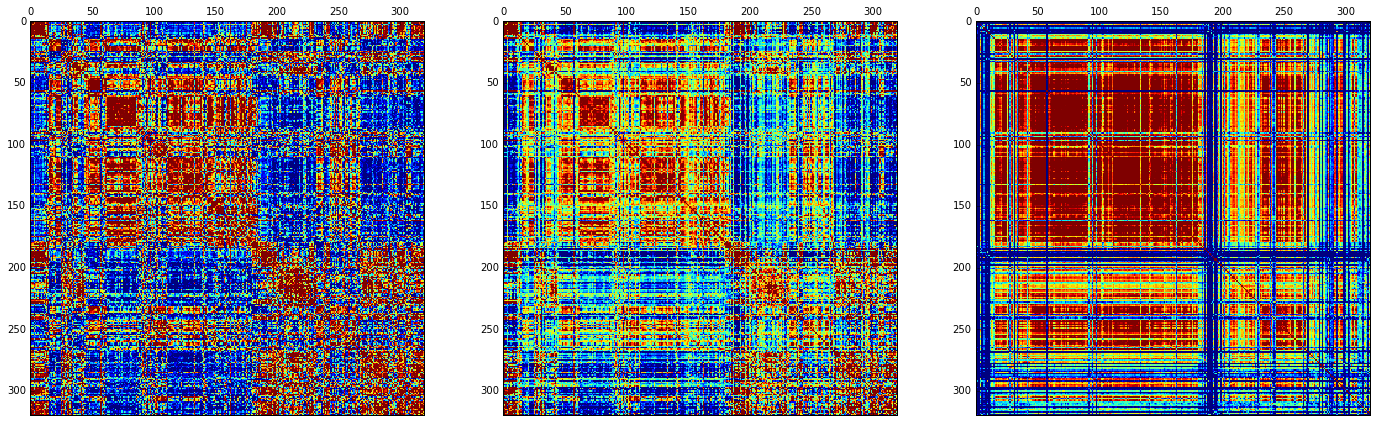

In [16]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [17]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering

X_ = demean(cor_mat)
# X_ = demean(stand(demean(cor_mat)))

clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_.values)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [18]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# edges = pd.DataFrame(demean(stand(demean(cor_mat))).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.9)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [19]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [20]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

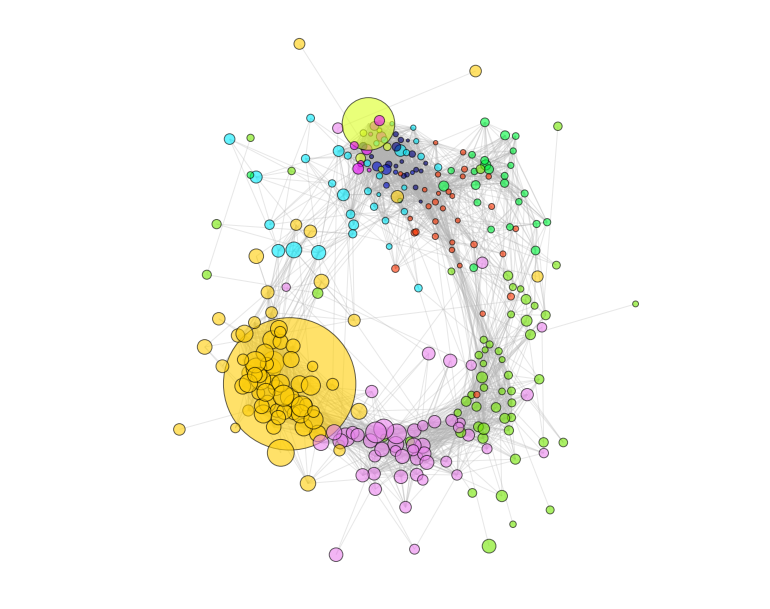

In [21]:
max_d = 40
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.35)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

In [22]:
xx

NameError: name 'xx' is not defined

### Draw in d3plus

In [23]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [24]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [25]:
nodes_.head()

,id,x,y,industry_title,color
0,1142,-7.433504,305.791785,NAICS 1142 Hunting and trapping,#00edff
1,5173,236.138008,-226.732696,NAICS 5173 Wired and wireless telecommunicatio...,#74e800
2,5171,180.717813,64.353301,NAICS12 5171 Wired telecommunications carriers,#ec84ef
3,1141,-58.897970,237.063310,NAICS 1141 Fishing,#00edff
4,3335,187.758321,234.199758,NAICS 3335 Metalworking machinery manufacturing,#00fd3f


In [26]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

In [27]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [28]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [29]:
## Conditional coloring

# Manufacturing (light_blue) and services (yellow)
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]

choices = ['#000080', '#ffc400', '#00b0ff', '#000000']

nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


/home/miglesia/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [30]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [31]:
nodes_.dropna().shape

(305, 7)

In [32]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

./modules/d3plus2.py:260: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  return data.rename_axis({self.id: self.network_id}, axis=1)


<IPython.core.display.Javascript object>

In [33]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

In [ ]:
nodes.groupby('cluster').color.unique()

### Activities by cluster

In [34]:

nodes.to_csv('./../data/naics_cluster_color.csv')

In [35]:
# Save total establishments by spectral analysis cluster, and county:
# xx
X_area_cluster = pd.concat([nodes[['cluster']], X.T], axis = 1)
X_area_cluster = X_area_cluster.iloc[10:]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
X_area_cluster.to_csv('./data/X_county_cluster.csv')

X_area_cluster.head()

cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
01001,1.6,0.000000,51.250000,7.400000,24.133333,0.6,560.683333,3.633333,0.000000,91.533333
01003,20.0,1.800000,141.150000,36.800000,151.400000,6.9,3299.600000,16.150000,9.066667,738.050000
01005,7.0,1.000000,55.000000,5.050000,23.250000,8.6,362.100000,2.400000,0.000000,63.066667
01007,0.6,0.333333,40.433333,3.466667,17.050000,5.6,177.700000,0.000000,1.000000,29.416667
01009,0.0,0.000000,65.550000,17.166667,18.616667,1.8,487.016667,3.233333,1.000000,90.950000


In [36]:
# X.T.iloc[10:].sum().sum()/1e6

In [37]:
clusters = nodes.loc[nodes.industry_title.str.contains('NAICS')].reset_index().rename(columns = {'index': 'industry_code'})[['industry_code', 'industry_title', 'cluster', 'color']]
clusters.to_csv('./data/clusters.csv', index = False)

In [38]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.loc[nodes.industry_title.str.contains('NAICS')].groupby('cluster').apply(lambda x: x.sample(3))#.agg({'industry_title': 'first', 'color':[ 'first', 'count']})
# summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

sqrt_size  cluster  \
cluster                             
0.0     2122  16.407823   0.0       
        4821  10.203757   0.0       
        5211  15.387766   0.0       
1.0     3365  15.475788   1.0       
        4861  17.953180   1.0       
        4862  33.399102   1.0       
2.0     2211  80.889122   2.0       
        4854  68.440729   2.0       
        6223  33.629848   2.0       
3.0     3219  97.785565   3.0       
        3261  103.068909  3.0       
        3315  45.880461   3.0       
4.0     3346  36.042336   4.0       
        4889  41.090550   4.0       
        7113  68.786627   4.0       
5.0     1133  95.919063   5.0       
        1153  44.597833   5.0       
        3211  59.307672   5.0       
6.0     4413  227.394444  6.0       
        4512  136.479058  6.0       
        4533  127.817448  6.0       
7.0     3169  26.623924   7.0       
        3274  18.728766   7.0       
        5174  29.219571   7.0       
8.0     1119  105.039278  8.0       
        1121  110.553682  8.0       
        1123  37.350368   8.0       
9.0     2362  226.266988  9.0       
        5121  144.296396  9.0       
        8129  161.834844  9.0       

                                                       industry_title    color  
cluster                                                                         
0.0     2122  NAICS 2122 Metal ore mining                              #000080  
        4821  NAICS 4821 Rail transportation                           #000080  
        5211  NAICS 5211 Monetary authorities - central bank           #000080  
1.0     3365  NAICS 3365 Railroad rolling stock manufacturing          #000ecd  
        4861  NAICS 4861 Pipeline transportation of crude oil          #000ecd  
        4862  NAICS 4862 Pipeline transportation of natural gas        #000ecd  
2.0     2211  NAICS 2211 Power generation and supply                   #00edff  
        4854  NAICS 4854 School and employee bus transportation        #00edff  
        6223  NAICS 6223 Other hospitals                               #00edff  
3.0     3219  NAICS 3219 Other wood product manufacturing              #00fd3f  
        3261  NAICS 3261 Plastics product manufacturing                #00fd3f  
        3315  NAICS 3315 Foundries                                     #00fd3f  
4.0     3346  NAICS 3346 Magnetic media manufacturing and reproducing  #74e800  
        4889  NAICS 4889 Other support activities for transportation   #74e800  
        7113  NAICS 7113 Promoters of performing arts and sports       #74e800  
5.0     1133  NAICS 1133 Logging                                       #dbff20  
        1153  NAICS 1153 Support activities for forestry               #dbff20  
        3211  NAICS 3211 Sawmills and wood preservation                #dbff20  
6.0     4413  NAICS 4413 Auto parts, accessories, and tire stores      #ffce05  
        4512  NAICS 4512 Book stores and news dealers                  #ffce05  
        4533  NAICS 4533 Used merchandise stores                       #ffce05  
7.0     3169  NAICS 3169 Other leather product manufacturing           #ff3400  
        3274  NAICS 3274 Lime and gypsum product manufacturing         #ff3400  
        5174  NAICS 5174 Satellite telecommunications                  #ff3400  
8.0     1119  NAICS 1119 Other crop farming                            #f107ff  
        1121  NAICS 1121 Cattle ranching and farming                   #f107ff  
        1123  NAICS 1123 Poultry and egg production                    #f107ff  
9.0     2362  NAICS 2362 Nonresidential building construction          #ec84ef  
        5121  NAICS 5121 Motion picture and video industries           #ec84ef  
        8129  NAICS 8129 Other personal services                       #ec84ef

In [39]:
nodes_['color'].value_counts().index

Index([u'#ffce05', u'#74e800', u'#ec84ef', u'#00edff', u'#ff3400', u'#00fd3f',
       u'#000080', u'#f107ff', u'#dbff20', u'#000ecd'],
      dtype='object')

In [40]:
# land-use clusters
nodes_.loc[nodes_['color'].isin(['#f10800', '#ff6800', '#ceff29', '#29ffce'])].sort_values(by = ['color','industry_title'])

#population cluster
nodes_.loc[nodes_['color'].isin(['#7dff7a'])].sort_values(by = ['color','industry_title'])

#'yellow' services cluster
nodes_.loc[nodes_['color'].isin(['#ffc400'])].sort_values(by = ['color','industry_title'])

#state/public sector cluster
# nodes_.loc[nodes_['color'].isin(['#004cff'])].sort_values(by = ['color','industry_title'])

#others/mfg clusters
# nodes_.loc[nodes_['color'].isin(['#000080', '#0000f1', '#00b0ff'])].sort_values(by = ['industry_title'])

# coastal?
# nodes_.loc[nodes_['color'].isin(['#0000f1'])].sort_values(by = ['color','industry_title'])

,id,x,y,industry_title,color,presence,color_mfg_srv


### Keywords by cluster

In [41]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from IPython.display import display, HTML
import colorlover as cl    
    
for clsr in range(10):
    try:
        
        text = nodes.loc[nodes.cluster == clsr]['industry_title']

        r1 = text.str.lower().str.split().values
        r1 = [item for sublist in r1 for item in sublist]

        r1_f = [w.replace(',', '').replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

#         print(summary.loc[clsr])
        color = summary.loc[clsr]['color']
#         display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))
        print(Counter(r1_f).most_common()[:10])
        print('\n')
    except:
        pass

[('naics', 16), ('transportation', 5), ('sightseeing', 3), ('scenic', 3), ('mills', 2), ('product', 2), ('water', 2), ('4832', 1), ('4879', 1), ('1122', 1)]


[('naics', 5), ('oil', 2), ('transportation', 2), ('gas', 2), ('pipeline', 2), ('activities', 1), ('mining', 1), ('4862', 1), ('2131', 1), ('crude', 1)]


[('naics', 36), ('manufacturing', 8), ('administration', 4), ('transportation', 4), ('production', 3), ('activities', 3), ('animal', 3), ('programs', 3), ('water', 2), ('support', 2)]


[('naics', 27), ('manufacturing', 21), ('product', 8), ('machinery', 4), ('equipment', 3), ('coating', 2), ('chemical', 2), ('electrical', 2), ('component', 2), ('commercial', 2)]


[('naics', 59), ('manufacturing', 10), ('merchant', 7), ('wholesalers', 7), ('transportation', 6), ('services', 6), ('support', 4), ('air', 3), ('goods', 3), ('naics02', 3)]


[('naics', 5), ('operations', 1), ('activities', 1), ('mining', 1), ('logging', 1), ('3211', 1), ('1133', 1), ('support', 1), ('area', 1), ('1

In [ ]:
display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))


### Map distribution from different clusters

In [ ]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP


In [ ]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
# nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

node_ids = neigh_ids

In [ ]:
# gdf.loc[gdf.industry_code == naics]['annual_avg_estabs']
# df_neigh
# df_neigh.groupby('industry_code').mean().sort_values(by = 'annual_avg_estabs').tail(5).index

In [ ]:
from PIL import Image, ImageDraw, ImageFont


In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

i = 0
open('./Figures/7_compo_USA_nw/labels.txt', 'w').close()
for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())

    # Sample of cluster color
    rgb_tuple = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))
    im = Image.new('RGBA', (20, 20), rgb_tuple)
    im.save('./Figures/7_compo_USA_nw/cp_'+str(i)+'.png')

    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .2 ):#& (i <=5): # Dismiss small indus
            node_info = nodes_.loc[nodes_.id == naics]
            
            # send node labels to test (they will then go to svg of figure)
            with open('./Figures/7_compo_USA_nw/labels.txt', 'a') as f:
                f.write(node_info['industry_title'].values[0]+'\n')
            display(node_info)
            display(HTML(cl.to_html( [rgb_tuple] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#             plt.axis('off')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.text(-128, 23.5, 'NAICS '+str(node_info['id'].values[0]), fontsize=30) # position in lat lon
            plt.savefig('./Figures/7_compo_USA_nw/'+str(node_info['id'].values[0])+'.png', bbox_inches = 'tight')
            plt.show()
    i+=1

In [ ]:
# TXT2InkscapeXMLv3.py

# A simple Python 3 script to look through a list of text and
# turn each line into an xml entry for use in Inkscape.
# in this script we will slightly spread the text to allow
# the user a better chance of retaining the order of their
# initial text.  Inkscape can be used to spread it out
# using the Align and Distribute Tool.


ofilenm = './Figures/7_compo_USA_nw/figure.svg'#str(input("What is the filename you wish for output?"))
outfile = open(ofilenm,"w")

ListFlm = './Figures/7_compo_USA_nw/labels.txt'#str(input("What is the name and location of the TXT file to work with?"))

Loctn = 75 #Vertical position to start text insertion
SpacingV = 25  #The vertical spacing between lines.

# The block that follows is the Inkscape standard header.
TextBlockA = '''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="744.09448819"
   height="1052.3622047"
   id="svg2"
   version="1.1"
   inkscape:version="0.48.4 r9939"
   sodipodi:docname="New document 1">
  <defs
     id="defs4" />
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.35"
     inkscape:cx="375"
     inkscape:cy="520"
     inkscape:document-units="px"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1280"
     inkscape:window-height="742"
     inkscape:window-x="-2"
     inkscape:window-y="-3"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata7">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1">'''

TextBlockB = '''<text\n
        xml:space="preserve"
        style="font-size:20px;font-style:normal;font-weight:normal;line-height:125%;letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;font-family:Sans"
        x="93.910118"
        y="'''
TextBlockC = '''id="text2989"
        sodipodi:linespacing="150%"><tspan
            sodipodi:role="line"
            id="tspan2991"
            x="93.910118"
            y="'''

outfile.write(TextBlockA)

# The section that follows is to build the SVG text elements
f = open(ListFlm,"r")
for line in f:
    TXTLine = line.strip()
    Loctn = Loctn + SpacingV
    InsertStrng1 = str(Loctn)+'"\n'
    InsertStrng2= str(Loctn)+'">'+TXTLine+'</tspan></text>\n'
    outfile.write(TextBlockB)
    outfile.write(InsertStrng1)
    outfile.write(TextBlockC)
    outfile.write(InsertStrng2)

# The next section is the close off for the SVG xml.

outfile.write('  </g>\n')
outfile.write('</svg>\n')

outfile.close()
print("Done")

In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())
    
    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .45 ):#& (i <=5): # Dismiss small indus
            display(nodes_.loc[nodes_.id == naics])
            display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
            plt.show()
            i+=1

### Color by Population Density

In [ ]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

In [ ]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [ ]:
nodes_

In [ ]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()